# CRAG(Corrective RAG)
Corrective retrieval-augmented generation (CRAG) is an improved version of RAG that aims to make language models more accurate.

While traditional RAG simply uses retrieved documents to help generate text, CRAG takes it a step further by actively checking and refining these documents to ensure they are relevant and accurate. This helps reduce errors or hallucinations where the model might produce incorrect or misleading information.

## 1. Setup

In [ ]:
!pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python

In [35]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

OPENAI_API_KEY: ··········


## 2. Setup proxy Knowledge Base

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://medium.com/@aakuskar.980/understanding-lstm-networks-a-simplified-explanation-3659be6b4923?source=user_profile_page---------0-------------5c9ca647dacc----------------------",
    "https://medium.com/@aakuskar.980/what-is-the-model-context-protocol-mcp-f6e287d62adc?source=user_profile_page---------2-------------5c9ca647dacc----------------------",
    "https://medium.com/@aakuskar.980/ai-agents-the-invisible-workforce-revolutionizing-our-world-a2905367f725?source=user_profile_page---------3-------------5c9ca647dacc----------------------",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)


vectorstore = Chroma.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings(),
    collection_name="proxy_knowledge_base",
)

retriever = vectorstore.as_retriever()


## 3. Set up a RAG chain

In [11]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

rag_prompt = hub.pull("rlm/rag-prompt")

rag_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

rag_chain = rag_prompt | rag_llm | StrOutputParser()

print(rag_prompt.messages[0].prompt.template)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [14]:
# Define the question you want to ask
question = "What is LSTM?"

# Now invoke the RAG chain with the defined question
generation = rag_chain.invoke({"context": docs, "question": question})
print("Question: %s" % question)
print("----")
print("Documents:\\n")
print('\\n\\n'.join(['- %s' % x.page_content for sublist in docs for x in sublist]))
print("----")
print("Final answer: %s" % generation)

Question: What is LSTM?
----
Documents:\n
- Understanding LSTM Networks: A Simplified Explanation | by Aditya Ak | MediumOpen in appSign upSign inWriteSign upSign inUnderstanding LSTM Networks: A Simplified ExplanationAditya AkFollow12 min read·Mar 3, 2025--ListenShareImagine you’re watching a movie. As the plot unfolds, you don’t forget what happened at the beginning, right? You remember the characters, their relationships, especially the actress, and how all of this helps you predict what will happen next. For example, if the hero loses their sword in the first scene, you know when they’ll pick it up later because your brain connects the dots!Now, think of a basic neural network as someone who watches the same movie but forgets everything after each scene. If you ask them, “Why is the hero fighting the villain?” they might say, “I don’t know, I forgot what happened earlier!” This is because basic neural networks process information step by step without retaining past information. The

## 4. Set up a retrieval evaluator
To improve the accuracy of the generated content, we set up a retrieval evaluator. This tool checks how relevant each retrieved document is to make sure only the most useful information is used.

In [19]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class RetrievalEvaluator(BaseModel):
    """Classify retrieved documents based on how relevant it is to the user's question."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
retrieval_evaluator_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_evaluator = retrieval_evaluator_llm.with_structured_output(RetrievalEvaluator)


# Prompt
system = """You are a document retrieval evaluator that's responsible for checking the relevancy of a retrieved document to the user's question. \\n
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \\n
    Output a binary score 'yes' or 'no' to indicate whether the document is relevant to the question."""

retrieval_evaluator_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \\n\\n {document} \\n\\n User question: {question}"),
    ]
)
retrieval_grader = retrieval_evaluator_prompt | structured_llm_evaluator


## 5. Setup question rewrite

In [20]:
question_rewriter_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
system = """You are a question re-writer that converts an input question to a better version that is optimized \\n
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \\n\\n {question} \\n Formulate an improved question.",
        ),
    ]
)
question_rewriter = re_write_prompt | question_rewriter_llm | StrOutputParser()

In [21]:
### Search
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

In [22]:
# Define the graph state
from typing import List
from typing_extensions import TypedDict
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

In [23]:
# Define function nodes
from langchain.schema import Document
def retrieve(state):
    """
    Retrieve documents
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]
    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}

In [24]:
def generate(state):
    """
    Generate answer
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [25]:
def evaluate_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    if len(filtered_docs) / len(documents) <= 0.7:
        web_search = "Yes"
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

In [26]:
def transform_query(state):
    """
    Transform the query to produce a better question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]
    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

In [27]:
def web_search(state):
    """
    Web search based on the re-phrased question.
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]
    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents, "question": question}

In [28]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    Args:
        state (dict): The current graph state
    Returns:
        str: Binary decision for next node to call
    """
    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    web_search = state["web_search"]
    state["documents"]
    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [29]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", evaluate_documents)  # evaluate documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)
# Compile
app = workflow.compile()

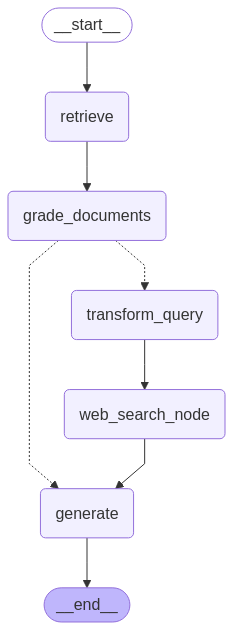

In [30]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [33]:
from pprint import pprint
# Run
inputs = {"question": "What's is LSTM?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        pprint(value, indent=2, width=80, depth=None)
    pprint("\\n---\\n")
# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
{ 'documents': [ Document(metadata={'description': 'Understanding LSTM networks  so ,Imagine you’re watching a movie. As the plot unfolds, you don’t forget what happened at the beginning, right? You remember the characters.......', 'source': 'https://medium.com/@aakuskar.980/understanding-lstm-networks-a-simplified-explanation-3659be6b4923?source=user_profile_page---------0-------------5c9ca647dacc----------------------', 'title': 'Understanding LSTM Networks: A Simplified Explanation | by Aditya Ak | Medium', 'language': 'en'}, page_content='Understanding LSTM Networks: A Simplified Explanation | by Aditya Ak | MediumOpen in appSign upSign inWriteSign upSign inUnderstanding LSTM Networks: A Simplified ExplanationAditya AkFollow12 min read·Mar 3, 2025--ListenShareImagine you’re watching a movie. As the plot unfolds, you don’t forget what happened at the beginning, right? You remember the characters, their relationships, especially the actress, and how 

In [34]:
from pprint import pprint
# Run
inputs = {"question": "What are features of MCP?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        pprint(value, indent=2, width=80, depth=None)
    pprint("\\n---\\n")
# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
{ 'documents': [ Document(metadata={'description': 'In the rapidly evolving world of AI, the Model Context Protocol (MCP) is gaining attention for a good reason. It acts as a communication bridge between AI models and external systems, enabling AI…', 'source': 'https://medium.com/@aakuskar.980/what-is-the-model-context-protocol-mcp-f6e287d62adc?source=user_profile_page---------2-------------5c9ca647dacc----------------------', 'title': 'What is the Model Context Protocol (MCP)? | by Aditya Ak | Mar, 2025 | Medium', 'language': 'en'}, page_content='interoperability.Communication Methods: Supports multiple communication methods, including STDIO and SSE, for flexibility in tool integration.Tool Integration: Enables language models to use external tools, enhancing their functionality and applicability.How Does MCP Work?MCP operates on a client-server architecture:MCP Hosts: These are the AI applications or interfaces, such as IDEs, or AI tools, that seek t